# Changlin Yi-cy2578
# FRE-6991 HW1

### Step 1: Download Data from Yahoo Finance

We download the adjusted close prices for the four stocks from 3/01/2024 to 03/01/2025 using the `yfinance` package.

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the tickers and date range
tickers = ['AAPL', 'XOM', 'PFE', 'ED']
start_date = '2024-03-01'
end_date = '2025-03-01'

# Download adjusted close prices and drop any missing data
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.dropna(inplace=True)
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,ED,PFE,XOM
Date,,,,
2024-03-01,178.815659,84.080727,25.021681,102.384132
2024-03-04,174.277115,86.129349,24.362968,100.952469
2024-03-05,169.320480,85.994064,24.541761,102.190666
2024-03-06,168.325195,86.825119,25.586290,103.283768
2024-03-07,168.205750,86.912079,25.209885,103.864182


### Step 2: Calculate Daily Returns

We compute the daily percentage returns for each stock.

In [5]:
daily_returns = data.pct_change().dropna()
daily_returns.head()

Ticker,AAPL,ED,PFE,XOM
Date,,,,
2024-03-04,-0.025381,0.024365,-0.026326,-0.013983
2024-03-05,-0.028441,-0.001571,0.007339,0.012265
2024-03-06,-0.005878,0.009664,0.042561,0.010697
2024-03-07,-0.000710,0.001002,-0.014711,0.005620
2024-03-08,0.010237,0.002001,0.016051,0.009407


### Step 3: Calculate and Plot 30-day Rolling Volatility and Correlation

**Volatility:**  
We calculate the rolling standard deviation of daily returns over a 30-day window and annualize it by multiplying by √252 (assuming 252 trading days per year).

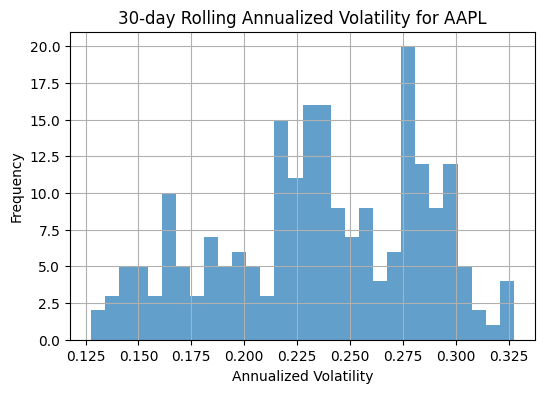

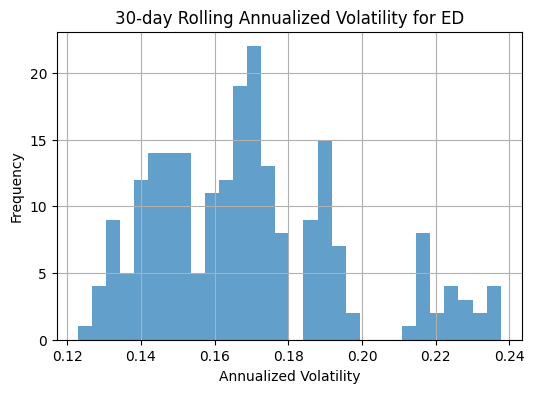

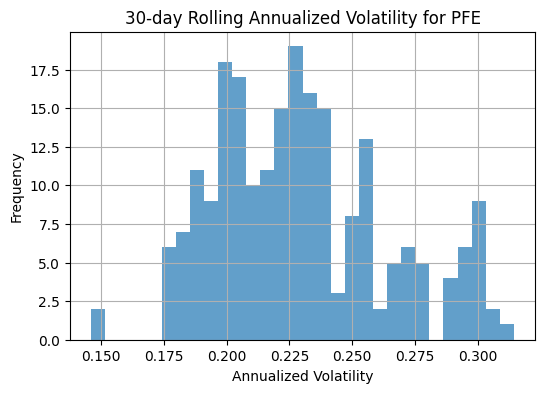

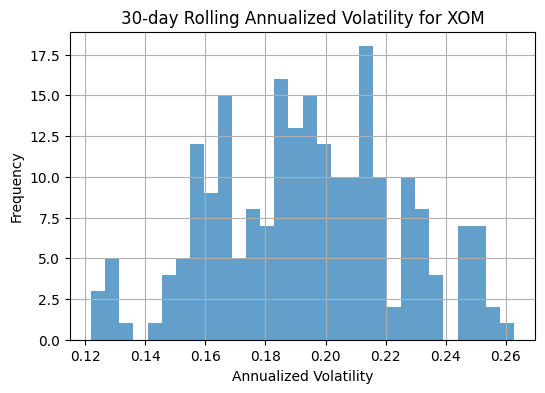

In [7]:
# Rolling 30-day volatility (annualized)
rolling_vol = daily_returns.rolling(window=30).std() * np.sqrt(252)
rolling_vol = rolling_vol.dropna()

# Plot separate histograms for each stock's 30-day rolling annualized volatility
for col in rolling_vol.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(rolling_vol[col], bins=30, alpha=0.7)
    plt.title(f'30-day Rolling Annualized Volatility for {col}')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

**Correlation:**  
For each 30-day window, we compute the correlation matrix among the stocks and extract the upper triangle values (excluding the diagonal). Then we plot the histogram of these correlation values.

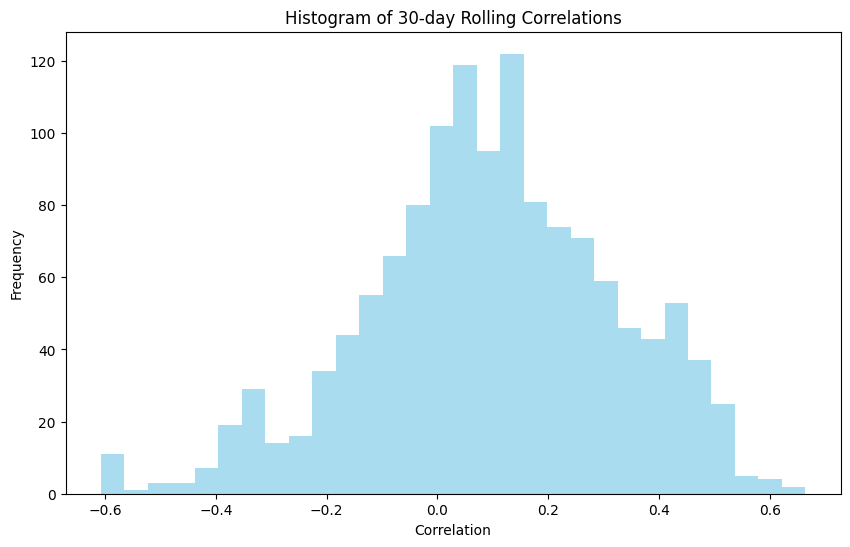

In [9]:
# Calculate rolling 30-day correlations.
rolling_corr_list = []
# Loop over each 30-day window in the daily returns DataFrame
for i in range(29, len(daily_returns)):
    window_data = daily_returns.iloc[i-29:i+1]
    corr_matrix = window_data.corr().values
    # Extract the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices_from(corr_matrix, k=1)
    rolling_corr_list.extend(corr_matrix[triu_indices])
rolling_corr_array = np.array(rolling_corr_list)

# Plot histogram of the rolling correlations
plt.figure(figsize=(10, 6))
plt.hist(rolling_corr_array, bins=30, alpha=0.7, color='skyblue')
plt.title('Histogram of 30-day Rolling Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()


### Step 4: Calculate Monthly Returns and Plot the Efficient Frontier

**Efficient Frontier:**  
We simulate a large number of random portfolios. For each portfolio, we calculate:

**Annualized Return:** Dot product of weights and annualized returns.
**Annualized Volatility:** The portfolio standard deviation using the annualized covariance matrix.
**Sharpe Ratio:** Using a risk-free rate of 2% (assumed).  

Finally, we plot the scatter of portfolio volatilities vs. returns and color the points by their Sharpe ratio.

/var/folders/9n/q6k7950n7xg1s3hmhsgf07fh0000gn/T/ipykernel_74301/3342745253.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()


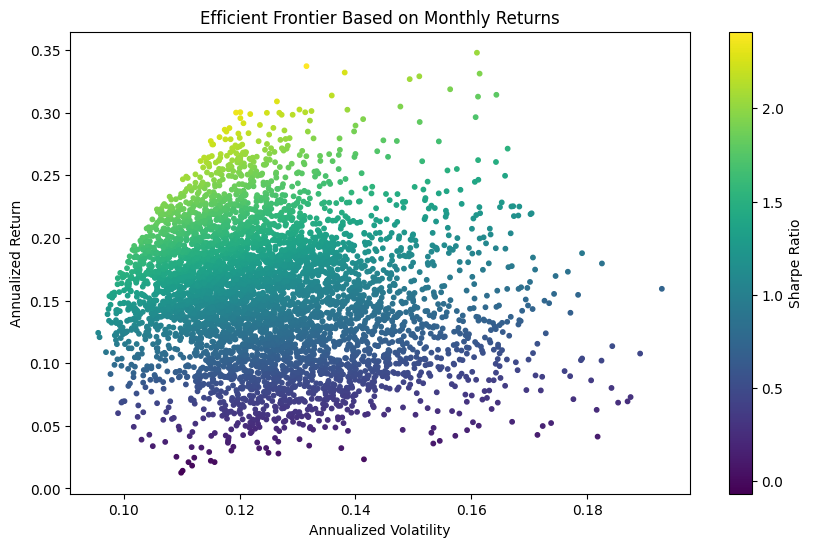

In [11]:
# Resample to monthly data (using the last price of each month)
monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

# Annualize the monthly returns and covariance
annual_returns = monthly_returns.mean() * 12
annual_cov = monthly_returns.cov() * 12

# Simulation: Generate random portfolios
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Random weights that sum to 1
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    # Portfolio return and volatility calculation
    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    results[0, i] = portfolio_volatility
    results[1, i] = portfolio_return
    results[2, i] = (portfolio_return - 0.02) / portfolio_volatility  # Sharpe ratio with risk-free rate = 2%

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o', s=10)
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier Based on Monthly Returns')
plt.show()
